# PTI-Clima Notebooks  <img src="https://www.r-project.org/logo/Rlogo.png" alt="Description" width="60" height="40">

***

> Este cuaderno o notebook muestra las operaciones básicas para calcular el Índice Meteorológico de Incendios (Fire Weather Index ;FWI) utilizando los conjuntos de datos de la PTI-Clima que se incluyen en el [almacén de datos](https://pti.climate.ifca.es/data). Este trabajo está licenciado bajo una [Licencia Creative Commons Atribución 4.0 Internacional](http://creativecommons.org/licenses/by/4.0).
>
> ![Licencia de Creative Commons](https://i.creativecommons.org/l/by/4.0/88x31.png)


## Guía para el cálculo del FWI

**O. Mirones** (Instituto de Física de Cantabria, CSIC-Universidad de Cantabria, Santander, Spain).

**¡Bienvenidos al cuaderno "Guía para el cálculo del FWI" de la Plataforma Virtual de Cálculo de la PTI-Clima!**  
Esta guía está diseñada para ayudarte a sacar el máximo provecho de los numerosos recursos disponibles en el [**Almacén de Datos de la PTI-Clima**](https://pti.climate.ifca.es/data). A través de esta plataforma, podrás realizar investigaciones y **análisis climáticos de relevancia**, ya que ofrece **acceso transparente a una amplia gama de materiales y datos** subyacentes a los **servicios climáticos desarrollados en la PTI-Clima**, fomentando su **reutilización** y posibilitando la **reproducibilidad** de los productos generados.

Concretamente en esta guía vamos a tratar de calcular el Índice Meteorológico de Incendios (Fire Weather Index), al que nos referiremos como FWI, a través de la plataforma. Esta guía se divide en varias secciones. Comenzaremos describiendo el objetivo general y algunas de las consideraciones importantes a tener en cuenta en el cálculo de dicho índice. A continuación, profundizaremos en la carga de datos de las variables necesarias así como operaciones básicas de los datos para adecuarlas al cálculo del índice. Finalmente, una vez cálculado realizaremos algunas visualizaciones, como gráficos espaciales o series temporales. **Te guiaremos a través de los pasos fundamentales para comenzar a trabajar de manera efectiva con datos climáticos**. Para esto último, utilizaremos el **framework *climate4R***, un conjunto de librerías de R para la carga, post-procesamiento y análisis de datos climáticos. 

<img src="https://raw.githubusercontent.com/SantanderMetGroup/climate4R/refs/heads/devel/man/figures/climate4R_logo.svg" alt="Description" width="60" height="40">

***climate4R*** ofrece más funcionalidades de las que se ilustran en este notebook, como **funcionalidades de operaciones espaciales y temporales** o como **interpolación, subsetting o intersección espacial**. Además, brinda funcionalidades para la **corrección de sesgo y downscaling** o funciones específicas para el **cálculo del FWI**. Consulta [Iturbide et al., 2019](https://www.sciencedirect.com/science/article/pii/S1364815218303049?via%3Dihub) y el repositorio de [github de climate4R](https://github.com/SantanderMetGroup/climate4R) para más información.

Antes de empezar definiremos el heap space de java.

In [1]:
options(java.parameters = "-Xmx20g")

### Contenido de este cuaderno:
*  [1 Características del FWI](#1-bullet)
   *  [1.1 Componentes del FWI](#1.1-bullet)
   *  [1.2 Datos necesarios](#1.2-bullet)
   *  [1.3 Consideraciones importantes](#1.3-bullet)
*  [2. ¿Cómo calcular el FWI en la plataforma?](#2-bullet)
   *  [2.1 Librerías de climate4R](#2.1-bullet)
   *  [2.2 Carga de variables](#2.2-bullet)
   *  [2.3 Cálculo del FWI](#2.3-bullet)
   *  [2.4 Visualizaciones espaciales y temporales](#2.4-bullet)
*  [3. Session Info](#3-bullet)

## 1 Características del FWI <a class="anchor" id="1-bullet"></a>

El FWI proporciona una métrica única para evaluar el peligro de incendio, derivada de **seis componentes interrelacionados**. Estos componentes representan colectivamente los efectos del clima en varias capas de combustible, desde la hojarasca superficial hasta la materia orgánica profunda.


### 1.1 Componentes del FWI <a class="anchor" id="1.1-bullet"></a>


+ 1. **Índice de Humedad de Combustible Fino (Fine Fuel Moisture Code; FFMC)**
      
       - Represents the moisture content of surface litter and fine fuels.
       - Afectado por las condiciones meteorológicas diarias como la temperatura, la humedad, la velocidad del viento y las precipitaciones.
       - Valores más altos indican combustibles finos más secos y más inflamables.
       
+ 2. **Índice de Humedad del Mantillo (Duff Moisture Code; DMC)**
      
       - Refleja el contenido de humedad de capas orgánicas sueltas y compactadas (por ejemplo, mantillo).
       - Sensible a las tendencias meteorológicas a más largo plazo, especialmente a las precipitaciones y la temperatura.
       - Valores más altos indican condiciones más secas y mayor combustibilidad.
       
+ 3. **Índice de Sequía (Drought Code; DC)**
      
       - Rastrea el contenido de humedad de capas orgánicas profundas y compactas, como el humus.
       - Responde lentamente a las precipitaciones y la temperatura, indicando tendencias de secado o humedecimiento a largo plazo.
       - Valores más altos significan un secado más profundo y un riesgo de incendio persistente.
       
+ 4. **Índice de Propagación Inicial (Initial Spread Index; ISI)**
      
       - Combina el FFMC y la velocidad del viento para estimar la posible tasa de propagación del fuego.
       - Valores más altos sugieren una propagación más rápida del fuego bajo las condiciones dadas.
       
+ 5. **Índice de Acumulación (Buildup Index; BUI)**
      
       - Combina el DMC y el DC para estimar el combustible total disponible para la combustión.
       - Valores altos implican una mayor cantidad de material combustible.
       
+ 6. **Fire Weather Index (FWI)**
        
       - Integra el ISI y el BUI para proporcionar una medida única del potencial de intensidad del fuego.
       - Valores altos indican mayor peligro e intensidad del fuego.


### 1.2 Datos necesarios <a class="anchor" id="1.2-bullet"></a>
Para el cálculo del FWI (y de sus componentes), necesitamos los siguientes datos meteorológicos:

+ **Temperatura (°C)**: Temperatura máxima diaria, que influye en el secado de los combustibles y la evaporación de la humedad.
+ **Humedad relativa (%)**: Humedad relativa mínima diaria, que afecta las tasas de evaporación y la humedad de los combustibles.
+ **Velocidad de viento (km/h)**: Velocidad media o máxima diaria del viento, crucial para evaluar el potencial de propagación del fuego.
+ **Precipitación (mm)**: Precipitación total diaria, que repone la humedad en las capas de combustible.

***ATENCIÓN*** : El cálculo del FWI se realiza con las variables medidas al mediodía de la hora local (noon local standard time). En el caso de la Península Ibérica la hora local equivale a las 12:00 UTC. Sin embargo, como veremos más adelante debido a la disponibilidad de datos, tendremos que realizar el cálculo del índice a través de medias diarias. Por tanto el índice que vamos a calcular va a resultar en una aproximación del FWI "verdadero". Sin embargo, el procedimiento de cálculo es análogo.

### 1.3 Consideraciones Importantes <a class="anchor" id="1.3-bullet"></a>

+ 1. **Marco Temporal**
     - El FWI generalmente se calcula diariamente, pero pueden ser necesarias actualizaciones en tiempo real en condiciones meteorológicas dinámicas.
+ 2. **Limitaciones**
     - El FWI no tiene en cuenta la humedad de la vegetación viva ni los efectos de los esfuerzos de supresión de incendios. Se enfoca únicamente en el potencial de incendios impulsado por el clima.
+ 3. **Aplicaciones**
     - Utilizado por agencias de gestión de incendios para la asignación de recursos, alertas públicas y preparación ante incendios forestales.

## 2 ¿Cómo calcular el FWI en la plataforma? <a class="anchor" id="2-bullet"></a>

### 2.1 Librerías de climate4R <a class="anchor" id="2.1-bullet"></a>

`climate4R` es un conjunto de paquetes de `R` diseñado para el acceso transparente a datos climáticos, procesamiento posterior (incluyendo la colocación de datos, corrección de sesgo y downscaling), y visualización. Se basa en dos estructuras principales de datos (rejilla y estación) para manejar datos de observaciones, reanálisis, pronósticos estacionales y proyecciones climáticas. Además, considera los miembros del conjunto como una dimensión básica de las estructuras de datos. A continuación, se describen las librerías de `climate4R` utilizadas en este cuaderno:

+ **loadeR**
  
  - Es un paquete de `R` para el acceso a datos climáticos basado en la API `NetCDF-Java`.
  - Permite un acceso fácil a datos desde ubicaciones locales o remotas (por ejemplo, servidores `OPeNDAP`).
  - Está completamente integrado con el `User Data Gateway (UDG)`, un servicio de datos climáticos mantenido por el ***Grupo de Meteorología de Santander***.
  - Ha sido concebido para trabajar en estudios de pronósticos estacionales y de cambio climático.


+ **transformeR**
  - Un paquete de `R` para la manipulación y transformación de datos climáticos.
  - Incluye funcionalidades como el recorte, remuestreo y conversión de datos.

+ **fireDanger**
  - Un paquete de `R` para la implementación del FWI.
  - Utiliza datos de pronósticos estacionales y otros conjuntos de datos climáticos como entrada.

+ **visualizeR**
  - Un paquete de `R` para la visualización de datos climáticos.
  - Está especialmente enfocado en los pronósticos por conjuntos y la comunicación de incertidumbre.
  - Incluye funciones para visualizar productos climatológicos, de pronóstico y de evaluación, así como combinaciones de estos.
+ **convertR**
  - Un paquete de `R` que realiza la conversión de unidades y la derivación de variables utilizando el Modelo de Datos Común de climate4R


In [2]:
library(loadeR)
library(transformeR)
library(fireDanger)
library(visualizeR)
library(RColorBrewer)
library(convertR)

Loading required package: rJava

Loading required package: loadeR.java

Java version 22x amd64 by N/A detected

NetCDF Java Library v4.6.0-SNAPSHOT (23 Apr 2015) loaded and ready

Loading required package: climate4R.UDG

climate4R.UDG version 0.2.6 (2023-06-26) is loaded

Please use 'citation("climate4R.UDG")' to cite this package.

loadeR version 1.8.1 (2023-06-22) is loaded


Get the latest stable version (1.8.2) using <devtools::install_github(c('SantanderMetGroup/climate4R.UDG','SantanderMetGroup/loadeR'))>

Please use 'citation("loadeR")' to cite this package.




    _______   ____  ___________________  __  ________ 
   / ___/ /  / /  |/  / __  /_  __/ __/ / / / / __  / 
  / /  / /  / / /|_/ / /_/ / / / / __/ / /_/ / /_/_/  
 / /__/ /__/ / /  / / __  / / / / /__ /___  / / \ \ 
 \___/____/_/_/  /_/_/ /_/ /_/  \___/    /_/\/   \_\ 
 
      github.com/SantanderMetGroup/climate4R



transformeR version 2.2.2 (2023-10-26) is loaded


Get the latest stable version (2.2.3) using <devtools::install_github('SantanderMetGroup/transformeR')>

Please see 'citation("transformeR")' to cite this package.

fireDanger version 1.1.0 (2018-10-04) is loaded

Type <vignette("Climate_Services_2017", package = "fireDanger")> for package overview and examples
Please use citation("fireDanger") to cite this package.

visualizeR version 1.6.4 (2023-10-26) is loaded

Please see 'citation("visualizeR")' to cite this package.

Loading required package: udunits2

udunits system database read from /opt/conda/envs/climate4r/lib/R/library/udunits2/share/udunits2.xml

convertR version 0.2.1 (2023-06-22) is loaded

  More information about the 'climate4R' ecosystem in: http://meteo.unican.es/climate4R


Attaching package: ‘convertR’


The following objects are masked from ‘package:loadeR’:

    hurs2huss, huss2hurs, tdps2hurs




### 2.2 Carga de variables <a class="anchor" id="2.2-bullet"></a>


El inventario (`data_inventory.csv`) cataloga la lista de archivos del [**Almacén de datos de la PTI-Clima**](https://pti.climate.ifca.es/data).

Simplemente necesitamos leer este archivo con la función `read.csv` para obtener el `data.frame` con esta información, que contiene seis columnas: `location`, `type`, `variable`, `project`, `experiment`, `frequency`.

In [3]:
df <- read.csv("../../data_inventory.csv")

Podremos ver las primeras filas del `data.frame` resultande con la función `head`.

In [4]:
head(df)

,dataset,type,access,source,provider,experiment,frequency,endpoint,dictionary
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,AEMET-5KM-regular_Iberia_day,observations,opendap,AEMET-5KM-regular,,,day,https://data.meteo.unican.es/thredds/dodsC/PTI-clima/observations/AEMET-5KM-regular_Iberia_day.ncml,../../Harmonization_dictionaries/AEMET-5KM-regular.dic
2,CHELSA-W5E5v1.0_Canarias_day,observations,opendap,CHELSA-W5E5v1.0,,,day,https://data.meteo.unican.es/thredds/dodsC/PTI-clima/observations/CHELSA-W5E5v1.0_Canarias_day.ncml,../../Harmonization_dictionaries/CHELSA-W5E5v1.0.dic
3,CHELSA-W5E5v1.0_Iberia_day,observations,opendap,CHELSA-W5E5v1.0,,,day,https://data.meteo.unican.es/thredds/dodsC/PTI-clima/observations/CHELSA-W5E5v1.0_Iberia_day.ncml,../../Harmonization_dictionaries/CHELSA-W5E5v1.0.dic
4,PTI-grid-v0_Canarias_day,observations,opendap,PTI-grid-v0,,,day,https://data.meteo.unican.es/thredds/dodsC/PTI-clima/observations/PTI-grid-v0_Canarias_day.ncml,../../Harmonization_dictionaries/PTI-grid-v0.dic
5,PTI-grid-v0_Iberia_day,observations,opendap,PTI-grid-v0,,,day,https://data.meteo.unican.es/thredds/dodsC/PTI-clima/observations/PTI-grid-v0_Iberia_day.ncml,../../Harmonization_dictionaries/PTI-grid-v0.dic
6,PTI-grid-v1_Canarias_day,observations,opendap,PTI-grid-v1,,,day,https://data.meteo.unican.es/thredds/dodsC/PTI-clima/observations/PTI-grid-v1_Canarias_day.ncml,../../Harmonization_dictionaries/PTI-grid-v1.dic


Se observan diferentes columnas o campos que describen los datos:

* `dataset` se refiere al nombre que se le da a cada instancia de datos en el almacén.
* `type` se refiere al tipo de los conjuntos de datos, ya sea "observaciones" (observations), "reanalisis" (reanalysis) o proyecciones (projections).
* `source` se refiere al conjuntos de datos de origen (p. ej., CORDEX-EUR, CMIP5, CMIP6, etc.).  
* `provider` se refiere a la entidad distribuidora de donde se obtuvieron los datos originales.  
* `access` se refiere al modo de acceso, ya sea local (netcdf) o remoto (opendap).
* `experiment` se refiere al escenario (p. ej., historical, rcp26, ssp126, rcp85, etc.).
* `frequency` se refiere a la escala temporal de los datos.
* `endpoint` se refiere a la ruta del archivo de datos. Esta ruta es la que se utilizará para cargar los datos más adelante.  

Podemos **aplicar fácilmente filtros** para obtener el archivo deseado. Por ejemplo, en este cuaderno vamos a calcular el índice con datos de ERA5-Land (reanálisis). En la siguiente celda podemos consultar todos los **datasets de reanálisis** disponibles.

In [5]:
subset(df, type == "reanalysis")

,dataset,type,access,source,provider,experiment,frequency,endpoint,dictionary
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
119,ERA5-Land_Canarias_day,reanalysis,opendap,ERA5-Land,ecmwf,,day,https://data.meteo.unican.es/thredds/dodsC/PTI-clima/reanalysis/ERA5-Land_Canarias_day.ncml,../../Harmonization_dictionaries/ERA5-Land.dic
120,ERA5-Land_Iberia_day,reanalysis,opendap,ERA5-Land,ecmwf,,day,https://data.meteo.unican.es/thredds/dodsC/PTI-clima/reanalysis/ERA5-Land_Iberia_day.ncml,../../Harmonization_dictionaries/ERA5-Land.dic


Seleccionamos el dataset `ERA5-Land_Iberia_day`, y extraemos la ruta del archivo de datos deseado correspondiente o `endpoint`.

In [6]:
endpoint <- subset(df, dataset == "ERA5-Land_Iberia_day")[["endpoint"]]

Una vez que tenemos el `endpoint`, podemos mostrar fácilmente las características de los datos que contiene. Para hacerlo, empleamos la función `dataInventory` del paquete `loadeR`.

In [7]:
di <- dataInventory(endpoint)

[2025-01-17 18:46:02.749198] Doing inventory ...

[2025-01-17 18:46:02.917082] Opening dataset...

[2025-01-17 18:46:14.470125] The dataset was successfuly opened

[2025-01-17 18:46:15.442287] Retrieving info for 'd2m' (7 vars remaining)

[2025-01-17 18:46:15.564303] Retrieving info for 'sfcwind' (6 vars remaining)

[2025-01-17 18:46:15.630387] Retrieving info for 'sp' (5 vars remaining)

[2025-01-17 18:46:15.69366] Retrieving info for 'ssrd' (4 vars remaining)

[2025-01-17 18:46:15.799774] Retrieving info for 't2m' (3 vars remaining)

[2025-01-17 18:46:15.86416] Retrieving info for 't2mn' (2 vars remaining)

[2025-01-17 18:46:15.93339] Retrieving info for 't2mx' (1 vars remaining)

[2025-01-17 18:46:15.995219] Retrieving info for 'tp' (0 vars remaining)

[2025-01-17 18:46:16.056265] Done.



Podemos echar un primer vistazo a la información disponible con `str`.

In [8]:
str(di)

List of 8
 $ d2m    :List of 7
  ..$ Description: chr "2 metre dewpoint temperature"
  ..$ DataType   : chr "float"
  ..$ Shape      : int [1:3] 26632 101 161
  ..$ Units      : chr "K"
  ..$ DataSizeMb : num 1732
  ..$ Version    : logi NA
  ..$ Dimensions :List of 3
  .. ..$ time     :List of 4
  .. .. ..$ Type      : chr "Time"
  .. .. ..$ TimeStep  : chr "1.0 days"
  .. .. ..$ Units     : chr "days since 1950-02-01 00:00:00"
  .. .. ..$ Date_range: chr "1950-02-01T00:00:00Z - 2022-12-31T00:00:00Z"
  .. ..$ latitude :List of 5
  .. .. ..$ Type       : chr "Lat"
  .. .. ..$ Units      : chr "degrees_north"
  .. .. ..$ Values     : num [1:101] 44 43.9 43.8 43.7 43.6 ...
  .. .. ..$ Shape      : int 101
  .. .. ..$ Coordinates: chr "latitude"
  .. ..$ longitude:List of 5
  .. .. ..$ Type       : chr "Lon"
  .. .. ..$ Units      : chr "degrees_east"
  .. .. ..$ Values     : num [1:161] -10 -9.9 -9.8 -9.7 -9.6 ...
  .. .. ..$ Shape      : int 161
  .. .. ..$ Coordinates: chr "longitude"


Vemos que hay varias variables disponibles: d2m, sfcwind, sp, ssrd, t2m, t2mn, t2mx, tp. Para cada una de ellas se detalla información adicional, como las unidades,el periodo temporal que cubren, las coordenadas etc. 

Existe la opción de **armonizar estos datos en el momento de la carga a través del uso de diccionarios**, que transforman unidades y nombres de variable al estándar establecido en este framework. Esto **se describe en detalle en el notebook `primeros_pasos_R.ipynb`**. También se ilustra en el notebook `intercomp_rejillas_obs_R.ipynb`. 

Sin embargo, **en este notebook ilustramos la posibilidad de realizar esas transformaciones a posteriori, por lo que no se utilizará el diccionario**.



Ahora, estamos en disposición de cargar las variables necesarias para el cálculo del índice. Como se mencionaba previamente en la sección [1.2 Datos necesarios](#1.2-bullet), necesitamos la temperatura, la humedad relativa, la precipitación y la velocidad del viento. Sin embargo, observamos en el catálogo cómo no está disponible la humedad. Para solucionarlo, aproximaremos la humedad relativa mediante la temperatura y el punto de rocío (d2m) mediante la función `tdps2hurs` del paquete `convertR`. 

***Atención*** : Es importante tener en cuenta que lo **óptimo es utilizar la variable humedad relativa**, al no estar dentro del conjunto de variables disponibles, estamos obligados a utilizar esta **aproximación** que en ningún caso es la humedad relativa real.

Utilizando la ayuda de la función `fwiGrid` del paquete fireDanger podemos ver que variables son necesarias y en que unidades deben estar estas, así como otras especificaciones de la función.

In [9]:
help(fwiGrid)

fwiGrid {fireDanger},R Documentation
multigrid,containing Tm (temperature records in deg. Celsius); H (relative humidity records in %); r (last 24-h accumulated precipitation in mm); W (wind velocity records in Km/h). See details.
mask,"Optional. Binary grid (0 and 1, 0 for sea areas) with dimensions attribute c(""lat"", ""lon"")."
what,"Character string. What component of the FWI system is computed?. Default to ""FWI"". Note that unlike fwi1D, only one single component choice is possible in fwiGrid. See fwi1D for details and possible values."
nlat.chunks,"For an efficient memory usage, the computation of FWI can be split into latitudinal bands (chunks) sepparately. The number of chunks is controlled here. Default to NULL (i.e., no chunking applied)."
restart.annual,"Logical. Should the calculation be restarted at the beginning of every year? If the grid encompasses just one season (e.g. JJA...), this is the recommended option. Default to TRUE."
parallel,Logical. Should parallel execution be used?
ncores,"Integer number of cores used in parallel computation. Self-selected number of cores is used when ncpus = NULL (the default), or when maxcores exceeds the default ncores value."
max.ncores,Integer. Upper bound for user-defined number of cores.
...,Further arguments passed to fwi1D.


La carga de datos se realiza mediante la función `loadGridData` especificando, como fuente de datos, la ruta de un archivo NetCDF o de un catálogo NcML. En nuestro caso, esa ruta es precisamente lo que encapsula el objeto `endpoint` que hemos definido anteriormente.

También es necesario especificar el parámetro `var`, que en este ejemplo se establece como `t2m` (temperatura superficial). Ten en cuenta que `loadGridData` permite establecer parámetros adicionales. Por ejemplo, podríamos utilizar los parámetros `lonLim` y `latLim` para cargar únicamente el subconjunto de datos correspondiente a una región más pequeña. Si no se emplean estos parámetros se carga el dominio completo (como en este caso). Otro parámetro útil es `season`, para cargar datos de meses específicos (más tarde lo utilizaremos para sacar el periodo JJAS, que es la temporada alta de incendios en la Península Ibérica). En el parámetro `years`, especificamos el periodo deseado (en este caso, 2016-2020). Ejecuta `help(loadGridData)` para consultar otros parámetros disponibles.  La carga de datos puede tardar segundos o minutos dependiendo de la cantidad de datos que corresponda a la petición que hagamos.

In [10]:
tas <- loadGridData(dataset = endpoint,
             var = "t2m",
             season = 1:12,
             years = 2016:2020)

[2025-01-17 18:46:17.600335] Opening dataset...

[2025-01-17 18:46:18.615923] The dataset was successfuly opened

[2025-01-17 18:46:18.62302] Defining geo-location parameters

[2025-01-17 18:46:18.774258] Defining time selection parameters

[2025-01-17 18:46:18.996181] Retrieving data subset ...

[2025-01-17 18:46:37.884212] Done



El objeto resultante (aquí llamado `tas`) es un *grid* de *climate4R*, que consiste en un objeto de tipo `list` con los siguientes slots: `Variable`, `Data`, `xyCoordinates`, `Dates` (y `Members` cuando se tratan de datos varios modelos, como ocurre con las proyecciones climáticas). Podemos comprobar la estructura, nombre de variable, unidades, etc. con la función `str`.

In [11]:
str(tas)

List of 4
 $ Variable:List of 2
  ..$ varName: chr "t2m"
  ..$ level  : NULL
  ..- attr(*, "use_dictionary")= logi FALSE
  ..- attr(*, "description")= chr "2 metre temperature"
  ..- attr(*, "units")= chr "K"
  ..- attr(*, "longname")= chr "t2m"
  ..- attr(*, "daily_agg_cellfun")= chr "none"
  ..- attr(*, "monthly_agg_cellfun")= chr "none"
  ..- attr(*, "verification_time")= chr "none"
 $ Data    : num [1:1827, 1:101, 1:161] NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...
  ..- attr(*, "dimensions")= chr [1:3] "time" "lat" "lon"
 $ xyCoords:List of 2
  ..$ x: num [1:161] -10 -9.9 -9.8 -9.7 -9.6 ...
  ..$ y: num [1:101] 34 34.1 34.2 34.3 34.4 ...
  ..- attr(*, "projection")= chr "LatLonProjection"
  ..- attr(*, "resX")= num 0.1
  ..- attr(*, "resY")= num 0.1
 $ Dates   :List of 2
  ..$ start: chr [1:1827] "2016-01-01 00:00:00 GMT" "2016-01-02 00:00:00 GMT" "2016-01-03 00:00:00 GMT" "2016-01-04 00:00:00 GMT" ...
  ..$ end  : chr [1:1827] "2016-01-01 00:00:00 GMT" "2016-01-02 00:00:00 GMT" "2

Repetimos el proceso con el resto de variables.

In [12]:
tp <- loadGridData(dataset = endpoint,
             var = "tp",
             season = 1:12,
             years = 2016:2020)

[2025-01-17 18:46:38.131564] Opening dataset...

[2025-01-17 18:46:39.159117] The dataset was successfuly opened

[2025-01-17 18:46:39.164233] Defining geo-location parameters

[2025-01-17 18:46:39.231235] Defining time selection parameters

[2025-01-17 18:46:39.410236] Retrieving data subset ...

[2025-01-17 18:46:57.188912] Done



In [13]:
sfcwind <- loadGridData(dataset = endpoint,
             var = "sfcwind",
             season = 1:12,
             years = 2016:2020)

[2025-01-17 18:46:57.411333] Opening dataset...

[2025-01-17 18:46:58.438324] The dataset was successfuly opened

[2025-01-17 18:46:58.443109] Defining geo-location parameters

[2025-01-17 18:46:58.508332] Defining time selection parameters

[2025-01-17 18:46:58.666647] Retrieving data subset ...

[2025-01-17 18:47:15.521144] Done



In [14]:
d2m <- loadGridData(dataset = endpoint,
             var = "d2m",
             season = 1:12,
             years = 2016:2020)

[2025-01-17 18:47:15.744039] Opening dataset...

[2025-01-17 18:47:16.779944] The dataset was successfuly opened

[2025-01-17 18:47:16.784913] Defining geo-location parameters

[2025-01-17 18:47:16.851413] Defining time selection parameters

[2025-01-17 18:47:17.008102] Retrieving data subset ...

[2025-01-17 18:47:33.083009] Done



Calculamos la aproximación de la humedad relativa mediante la temperatura y el punto de rocío utilizando la función mencionada previamente.

In [15]:
hurs <- tdps2hurs(tdps = d2m, tas = tas, negatives.to.zero = TRUE)

[2025-01-17 18:47:37.964437] Converting temperature units ...

[2025-01-17 18:47:43.846617] Converting temperature units ...

[2025-01-17 18:47:49.708886] Deriving relative humidity ...

[2025-01-17 18:47:56.704664] Done.



Por último, observamos las unidades de las variables que se involucran en el calculo del FWI. Como se remarca en la ayuda de la función `fwiGrid`, las variables que se introducen como input deben estar en unas unidades específicas. Mediante el atributo `units` disponible en `Variables` podemos acceder a esta información.

In [16]:
print(attributes(tas[['Variable']])['units'])

$units
[1] "K"



In [17]:
print(attributes(sfcwind[['Variable']])['units'])

$units
[1] "m s**-1"



In [18]:
print(attributes(tp[['Variable']])['units'])

$units
[1] "m"



Hacemos los cambios en las unidades de las variables involucradas. Para ello manipulamos el elemento `$Data` que recoge los valores numéricos del grid de la variable. Finalmente cambiamos el nombre de la variable para que concuerden con los nombres que exige la función `fwiGrid`. Para ello manipulamos el elemento `$Variable$varName` así como el atributo `units`.

In [19]:
#K to C
tas$Data <- tas$Data -273.15
tas$Variable$varName <- "tas"
attr(tas$Variable, "units") <- "C"

#m to mm
tp$Data <- tp$Data*1000
attr(tp$Variable, "units") <- "mm"

#m/s to km/h
sfcwind$Data <- sfcwind$Data*3.6
sfcwind$Variable$varName <- "wss"
attr(sfcwind$Variable, "units") <- "km.h-1"

### 2.3 Cálculo del FWI <a class="anchor" id="2.3-bullet"></a>

Finalmente, creamos el multigrid con las variables utilizando `makeMultiGrid` y el objeto que retorna se lo pasamos como input a `fwiGrid`. En la función añadimos los argumentos `what = "FWI"` para señalar que índice queremos calcular y `restart.annual = FALSE` para evitar que el FWI se inicialice cada año.

In [20]:
#creamos el multigrid
mg <- makeMultiGrid(tas, tp, sfcwind, hurs)

#eliminamos las variables para liberar espacio
rm(tas)
rm(tp)
rm(sfcwind)
rm(hurs)
gc()

#calculamos el FWI
fwi <- fwiGrid(mg, what = "FWI", restart.annual = FALSE)

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1543897,82.5,2460437,131.5,2460437,131.5
Vcells,151367638,1154.9,603316044,4603.0,745637778,5688.8


[2025-01-17 18:48:19.807413] Calculating FWI

[2025-01-17 18:48:33.774171] Processing chunk 1 out of 1...

[2025-01-17 18:50:20.240197] Done.



### 2.4 Visualizaciones espaciales y temporales <a class="anchor" id="2.4-bullet"></a>

Mediante la función `temporalPlot` del paquete `visualizeR` podemos mostrar la serie temporal diaria promedia de la región. En el gráfico resultante se observan los ciclos anuales del FWI en los periodos de riesgo alto (Junio-Septiembre).

pad applied on the interval: day



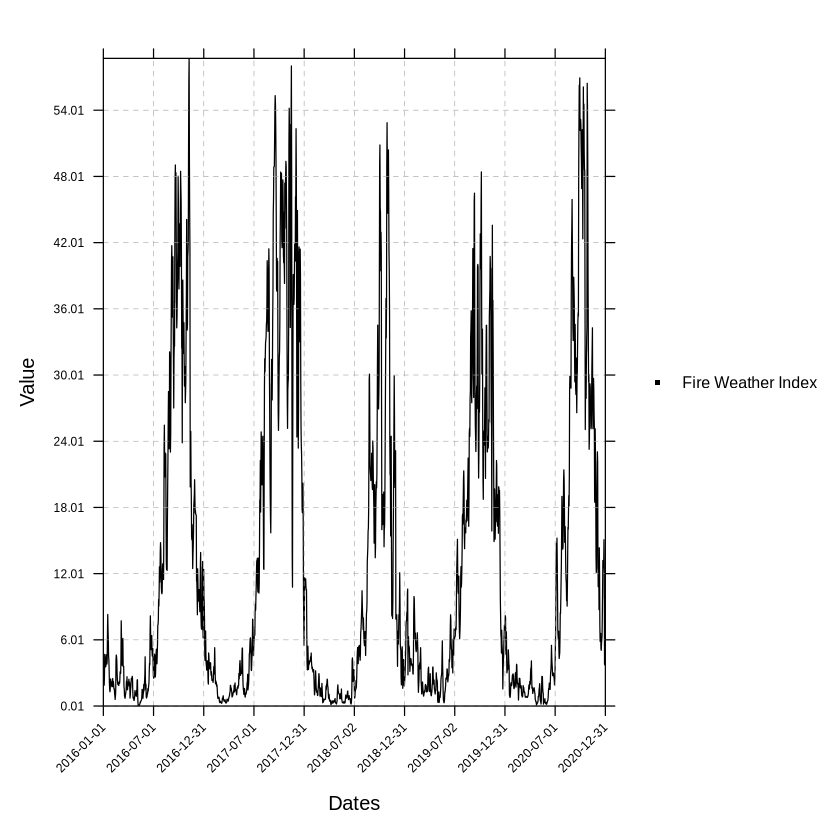

In [21]:
temporalPlot("Fire Weather Index" = fwi)

Para la visualización espacial, vamos a mostrar la climatología de los meses desde Junio hasta Septiembre, donde el índice alcanza sus cotas máximas. Para solamente considerar estos meses usamos el argumento `season = 6:9` de la función `subsetGrid`, guardando el resultado en un nuevo objeto `fwi.jjas`. A través de `spatialPlot` pintamos la climatología. Para ello, primero calculamos la climatología con la función `climatology` del paquete `transformeR`. Esta función agrega la dimensión temporal de los datos utilizando la media como función por defecto, sin embargo, podríamos utilizar cualquier otra función a través del parámetro `clim.fun` (p.ej. `climatology(fwi.jjas, clim.fun = list("max", na.rm = TRUE)`). Posteriormente, utilizamos la función `spatialPlot` del paquete `visualizeR` (ejecuta `help(spatialPlot)` para consultar diferentes parámetros de representación gráfica).

In [22]:
#creamos la paleta de colores
fwi.colors <- colorRampPalette(c(rev(brewer.pal(9, "YlGnBu")[3:5]), 
                                 brewer.pal(9, "YlOrRd")[3:9]))

fwi.jjas <- subsetGrid(fwi, season = 6:9)

[2025-01-17 18:50:32.366182] - Computing climatology...

[2025-01-17 18:50:32.71549] - Done.



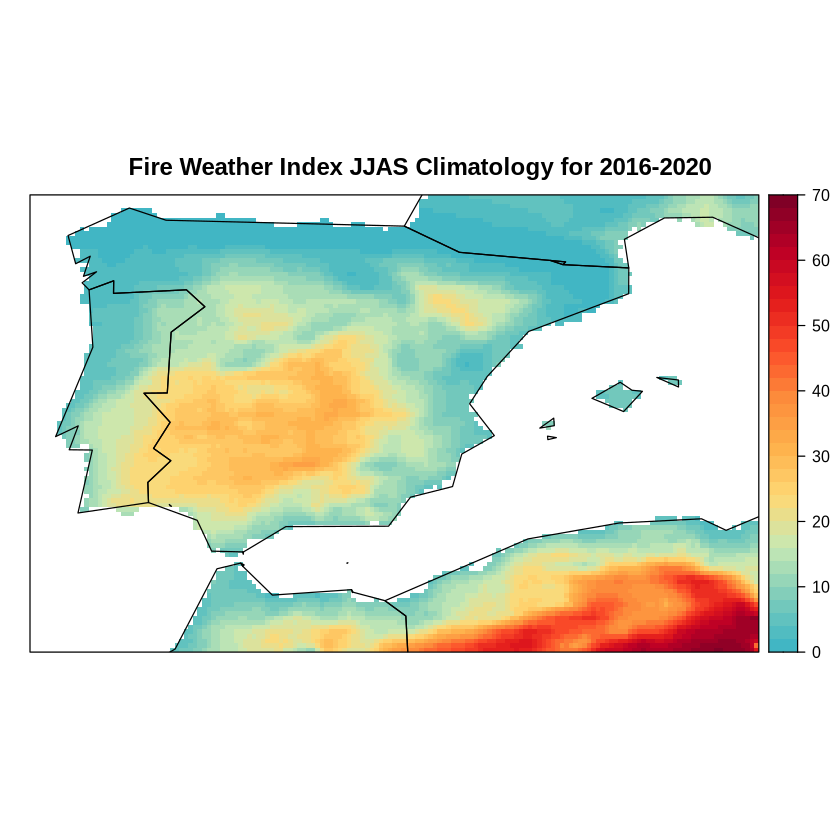

In [23]:
#dibujamos la climatología
spatialPlot(climatology(fwi.jjas), 
            backdrop.theme = 'countries', 
            col.regions = fwi.colors,
            main = "Fire Weather Index JJAS Climatology for 2016-2020",
            set.min = 0, at = seq(0,70,2))

El **framework *climate4R*** ofrece muchas otras **funcionalidades de operaciones espaciales y temporales**, como **interpolación, subsetting o intersección espacial**. Además, brinda funcionalidades para la **corrección de sesgo y downscaling**. Consulta [Iturbide et al., 2019](https://www.sciencedirect.com/science/article/pii/S1364815218303049?via%3Dihub) y el repositorio de [github de climate4R](https://github.com/SantanderMetGroup/climate4R) para más información.

## 3 Session Info <a class="anchor" id="3-bullet"></a>


In [24]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 22.04.3 LTS

Matrix products: default
BLAS/LAPACK: /opt/conda/envs/climate4r/lib/libopenblasp-r0.3.27.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8          LC_NUMERIC=C                 
 [3] LC_TIME=en_US.UTF-8           LC_COLLATE=en_US.UTF-8       
 [5] LC_MONETARY=en_US.UTF-8       LC_MESSAGES=en_US.UTF-8      
 [7] LC_PAPER=en_US.UTF-8          LC_NAME=en_US.UTF-8          
 [9] LC_ADDRESS=en_US.UTF-8        LC_TELEPHONE=en_US.UTF-8     
[11] LC_MEASUREMENT=en_US.UTF-8    LC_IDENTIFICATION=en_US.UTF-8

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] convertR_0.2.1      udunits2_0.13.2.1   RColorBrewer_1.1-3 
 [4] visualizeR_1.6.4    fireDanger_1.1.0    transformeR_2.2.2  
 [7] loadeR_1.8.1        climate4R.UDG_0.2.6 loadeR.java_1.1.1  
[10] rJav